# ABIN Assignment 2 [Akshat Kumar, 2023060]

***A study of nucleotide encoding and network architecture for genomic sequence classification.***

in this project i will use the dataset from the "a primer on deep learning in genomics" notebook (given in the assignment) to build and evaluate several neural network models. the goal is to solve a binary classification task: predicting if a dna sequence binds to a transcription factor.

i will investigate:

1. three different nucleotide encoding strategies (label, one-hot, fcgr) with a minimal ANN.

2. a full diagnostic analysis of the best ANN model .

3. the effect of network depth and activation functions (linear, sigmoid) on ANN performance .

4. the implementation and performance of a 1d convolutional neural network (CNN) for the same task .

# Global Setup: rules & utilities

step 1: importing all necessary libraries. i'll start by importing python libraries for data handling (numpy, pandas, requests), plotting (matplotlib, seaborn), machine learning (tensorflow.keras), and evaluation (sklearn).

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import random
import string # needed for fcgr

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.utils import class_weight

step 2: fixing all random seeds for reproducibility.
(this is a global rule). i'll create a function to set the seeds for python, numpy, and tensorflow to ensure my results are the same every time i run the code.

In [17]:
#set a single seed for all random operations
seed = 42

def set_all_seeds(seed):
    """fixes all random seeds for reproducibility."""
    os.environ['pythonhashseed'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['tf_deterministic_ops'] = '1'

set_all_seeds(seed)
print(f"all random seeds set to {seed}.")

all random seeds set to 42.


step 3: loading the raw sequence data.

i'll load the sequences and labels from the urls provided in the source notebook; also converted the string labels ('0', '1') into integers (0, 1) for easier processing.

In [18]:
# --- load data ---
sequences_url = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
labels_url = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

print("loading data from urls...")
raw_sequences = requests.get(sequences_url).text.split('\n')
raw_labels = requests.get(labels_url).text.split('\n')

# clean up empty strings that result from the split('\n')
sequences = [seq.strip().upper() for seq in raw_sequences if seq] # also standardize to upper
labels_str = [label for label in raw_labels if label]

# convert string labels '0', '1' to integers 0, 1
# better for binary classification and stratification
labels = np.array([int(l) for l in labels_str])

print(f"successfully loaded {len(sequences)} sequences.")
print(f"successfully loaded {len(labels)} labels.")
print("\nexample sequence:", sequences[0])
print("example label:", labels[0])

loading data from urls...
successfully loaded 2000 sequences.
successfully loaded 2000 labels.

example sequence: CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC
example label: 0


step 4: creating global utility functions (as req by rules)

main helper functions required by the global rules:

a. split_data: performs a single, stratified 70/15/15 train/validation/test split.

b. report_metrics: calculates all required metrics (acc, prec, rec, f1, roc-auc) and plots a confusion matrix.

c. plot_history: a helper to plot training/validation loss and accuracy curves (for q2, q3, q4).

In [25]:
# -train/validation/test split function (70/15/15)
def split_data(x_data, y_data):
    # creates a single, reproducible 70/15/15 stratified split.
    # first split: 70% train, 30% temp (for val + test)
    x_train, x_temp, y_train, y_temp = train_test_split(
        x_data, y_data,
        test_size=0.30,
        random_state=seed,
        stratify=y_data
    )

    # second split: 50% of temp to val, 50% to test (0.15 / 0.15 of total)
    x_val, x_test, y_val, y_test = train_test_split(
        x_temp, y_temp,
        test_size=0.50,
        random_state=seed,
        stratify=y_temp
    )

    return x_train, x_val, x_test, y_train, y_val, y_test

#metrics reporting function
#
def report_metrics(y_true, y_prob_pred, model_name="model"):
    """
    reports all required metrics and plots a normalized confusion matrix.
    y_true: the true labels (0 or 1)
    y_prob_pred: the predicted probabilities from model.predict()
    """

    # for binary models with sigmoid output, shape is (n, 1)
    # for models with softmax, shape is (n, 2), so we take prob of class 1
    if y_prob_pred.ndim > 1 and y_prob_pred.shape[1] > 1:
        y_prob = y_prob_pred[:, 1] # probability of class 1
    else:
        y_prob = y_prob_pred.flatten() # ensure it's 1d

    # convert probabilities to binary predictions (0 or 1)
    y_pred = (y_prob > 0.5).astype(int)

    # for roc-auc, use the raw probabilities
    try:
        roc_val = roc_auc_score(y_true, y_prob)
    except ValueError as e:
        print(f"could not calculate roc-auc: {e}")
        roc_val = np.nan

    print(f"\n--- metrics report for: {model_name} ---")

    # calculating metrics
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1-score": f1_score(y_true, y_pred),
        "roc-auc": roc_val
    }

    # printing metrics in a clean table
    for metric, value in metrics.items():
        print(f"  {metric:<10}: {value:.4f}")
    print("----------------------------------------")

    # plot normalized confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['predicted 0 (no bind)'],
                yticklabels=['actual 0 (no bind)'])

    # fix for seaborn heatmap bug in some versions
    plt.yticks(ticks=[0.5, 1.5], labels=['actual 0 (no bind)', 'actual 1 (bind)'], rotation=0)
    plt.xticks(ticks=[0.5, 1.5], labels=['predicted 0 (no bind)', 'predicted 1 (bind)'], rotation=0)

    plt.title(f'normalized confusion matrix - {model_name}')
    plt.ylabel('actual label')
    plt.xlabel('predicted label')
    plt.show()

    return metrics

#plot training curves
def plot_history(history, model_name="model"):
    """plots training/validation loss and accuracy curves."""
    history_df = pd.DataFrame(history.history)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # find the primary metric name
    metric_name = [k for k in history_df.keys() if 'accuracy' in k and 'val_' not in k][0]
    val_metric_name = f'val_{metric_name}'

    # plot loss
    ax1.plot(history_df['loss'], label='train loss')
    ax1.plot(history_df['val_loss'], label='validation loss')
    ax1.set_title(f'{model_name} loss curves')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # plot accuracy
    ax2.plot(history_df[metric_name], label=f'train {metric_name.replace("_", " ")}')
    ax2.plot(history_df[val_metric_name], label=f'validation {metric_name.replace("_", " ")}')
    ax2.set_title(f'{model_name} accuracy curves')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

# q1. Turning nucleotides into numbers for ANN

## q1.a: implementation 1 (label encoding)

step 1: first, i need to convert the raw dna strings (e.g., 'acgt') into numeric tensors that an ann can understand. my first strategy is label encoding, which maps each nucleotide to a unique integer (a=0, c=1, g=2, t=3).

i'll write a function to do this and then apply it to our sequences

In [26]:
def encode_sequences_label(sequences):
    # encodes dna sequences using simple label encoding (a=0, c=1, g=2, t=3).
    # creating the mapping
    base_map = {'a': 0, 'c': 1, 'g': 2, 't': 3, 'n': 4} # 'n' for any unknown
    encoded_seqs = []
    for seq in sequences:
        encoded_seq = [base_map[base.lower()] for base in seq]
        encoded_seqs.append(encoded_seq)

    return np.array(encoded_seqs, dtype='float32')

# 1. encode the raw sequences
x_label_encoded = encode_sequences_label(sequences)
print(f"shape of label-encoded data: {x_label_encoded.shape}")
print(f"example encoded sequence:\n{x_label_encoded[0]}")

shape of label-encoded data: (2000, 50)
example encoded sequence:
[1. 1. 2. 0. 2. 2. 2. 1. 3. 0. 3. 2. 2. 3. 3. 3. 2. 2. 0. 0. 2. 3. 3. 0.
 2. 0. 0. 1. 1. 1. 3. 2. 2. 2. 2. 1. 3. 3. 1. 3. 1. 2. 1. 2. 2. 0. 1. 0.
 1. 1.]


step 2: splitting the data.

now i'll use my global split_data function to create the 70/15/15 stratified split on this newly encoded data.

In [27]:
# 2. split the data using our global function
#use the original 'labels' array (0s and 1s) for y
x_train_lab, x_val_lab, x_test_lab, y_train, y_val, y_test = split_data(x_label_encoded, labels)

step 3: defining the minimal ANN.

as required, i'll define a minimal ANN . for label-encoded data, the input is a 1d vector of 50 integers. my minimal ANN will have:
 > a single hidden dense layer with 16 neurons (using 'relu').

 > an output dense layer with 1 neuron and a 'sigmoid' activation for our binary classification task.

i'm not using a flatten layer here because the input data (batch_size, 50) is already 1d

In [28]:
# 3. define the minimal ANN builder function
def build_ann_label(input_shape=(50,)):
    # builds a minimal ANN for 1d label-encoded data.
    set_all_seeds(seed) # ensure model weights are reproducible
    model = Sequential()

    # input layer: specify input shape for the 1d vector
    model.add(Dense(16, activation='relu', input_shape=input_shape))

    # output layer: 1 neuron, sigmoid for binary classification
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    return model

#build and summarize the model
model_lab = build_ann_label()
model_lab.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

step 4: training the minimal ANN

i'll train the model on the x_train_lab data and use x_val_lab for validation. i'll also use class_weight to handle the slight class imbalance (as seen in the source notebook, though data is balanced, STILL a good practice).

In [29]:
# 4. train the model
print("training label-encoded ann...")

# calculate class weights
class_weights_lab = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_lab = dict(enumerate(class_weights_lab))

history_lab = model_lab.fit(
    x_train_lab,
    y_train,
    epochs=50,
    validation_data=(x_val_lab, y_val),
    class_weight=class_weights_lab,
    verbose=0  # noteeee: set to 1 if want to see epoch-by-epoch output
)

print("training complete.")

training label-encoded ann...
training complete.


step 5: evaluating the model

now i'll use my helper functions to plot the training history and report the final test metrics.

evaluating label-encoded ANN...


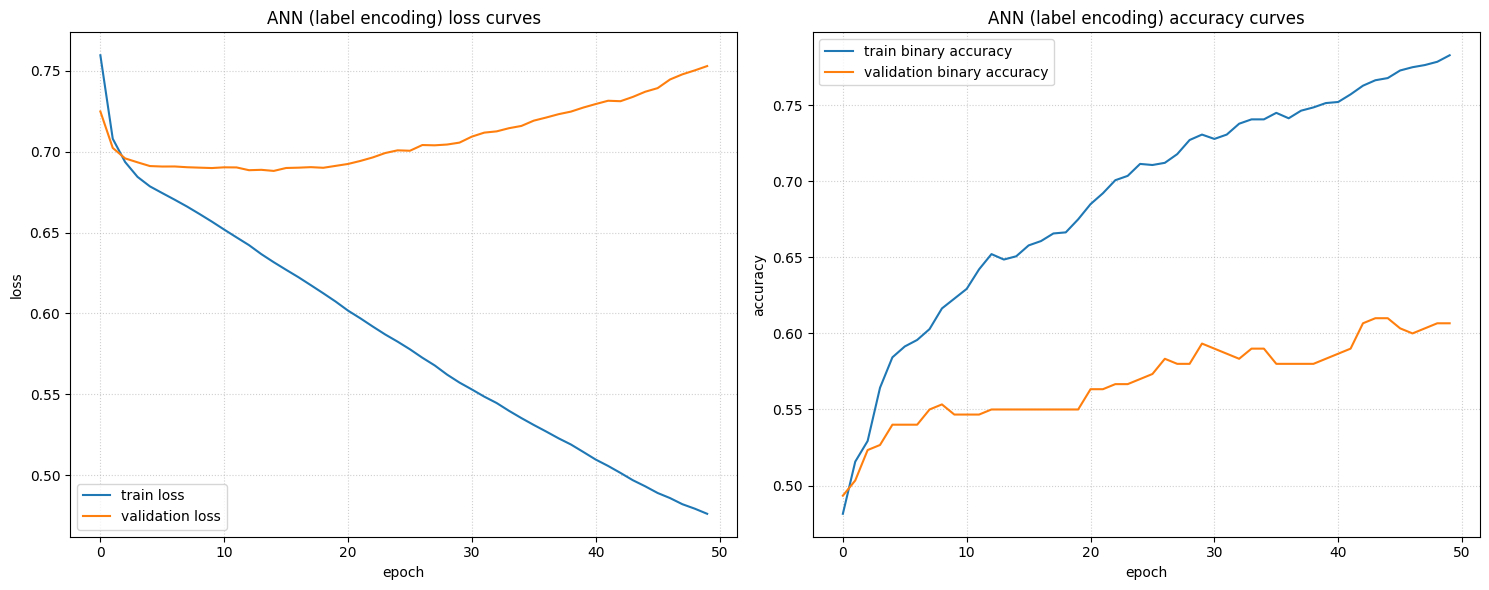

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

--- metrics report for: ANN (label encoding) ---
  accuracy  : 0.5267
  precision : 0.5170
  recall    : 0.6149
  f1-score  : 0.5617
  roc-auc   : 0.5557
----------------------------------------


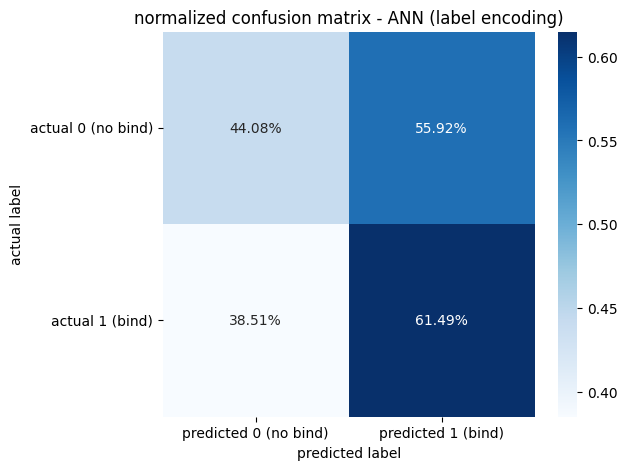

In [30]:
# 5. evaluating the model
print("evaluating label-encoded ANN...")
# plot loss and accuracy curves
plot_history(history_lab, model_name="ANN (label encoding)")
# get probability predictions on the test set
y_prob_lab = model_lab.predict(x_test_lab)
# report all metrics
metrics_lab = report_metrics(y_test, y_prob_lab, model_name="ANN (label encoding)")

***pros and cons of label encoding***

pros:
1. it's very simple to implement.
2. it's memory-efficient, converting a sequence of 50 characters into a vector of 50 integers.

cons:
1. it introduces a false ordinal relationship . the model will learn that $t=3 > g=2 > c=1 > a=0$, which is biologically meaningless. this artificial ordering can confuse the model and make it harder to learn the true patterns.

## q1.b: implementation 2 (one-hot encoding)

step 1:
the second encoding strategy. one-hot encoding (ohe) converts each nucleotide into a vector of four (e.g., a=[1,0,0,0], c=[0,1,0,0]). this is the method used in the source notebook.

i'll write a function to convert all 50-base sequences into (50, 4) matrices.

In [31]:
def encode_sequences_onehot(sequences):
    #encodes dna sequences using one-hot encoding.
    # use the labelencoder/onehotencoder combo (from the source notebook)
    #robust way to handle it
    integer_encoder = LabelEncoder()
    # using 'auto' for categories, though could specify [['a'], ['c'], ['g'], ['t']]
    one_hot_encoder = OneHotEncoder(categories='auto', sparse_output=False, dtype=np.float32)
    encoded_seqs = []
    for seq in sequences:
        # 1. convert string to list of chars
        char_list = list(seq.lower())

        # 2. integer encode
        integer_encoded = integer_encoder.fit_transform(char_list)

        # 3. reshape for one-hot encoder
        integer_encoded_reshaped = integer_encoded.reshape(len(integer_encoded), 1)

        # 4. one-hot encode
        one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded_reshaped)
        encoded_seqs.append(one_hot_encoded)

    return np.array(encoded_seqs)

# 1. encode the raw sequences
x_ohe_encoded = encode_sequences_onehot(sequences)
print(f"shape of one-hot encoded data: {x_ohe_encoded.shape}")
print(f"example encoded sequence (first 5 bases of seq 0):\n{x_ohe_encoded[0][:5]}")

shape of one-hot encoded data: (2000, 50, 4)
example encoded sequence (first 5 bases of seq 0):
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


Step 2: splitting the data
i'll use the same global split_data function. this time, x_data is my 3d numpy array x_ohe_encoded

In [32]:
# note pls: we use the original 'labels' array (0s and 1s) for y
x_train_ohe, x_val_ohe, x_test_ohe, y_train, y_val, y_test = split_data(x_ohe_encoded, labels)

step 3: defining the Minimal ANN (with Flatten)
this ANN will be slightly different from q1.a. because the input data is 2d (50, 4), i must use a flatten layer first to convert it into a 1d vector before feeding it to the dense layer.

In [33]:
#define the minimal ANN builder function for ohe data
def build_ann_ohe(input_shape=(50, 4)):
    #builds a minimal ANN for 2d one-hot-encoded data.
    set_all_seeds(seed) # ensure model weights are reproducible
    model = Sequential()

    # input layer: flatten the (50, 4) matrix into a (200,) vector
    model.add(Flatten(input_shape=input_shape))

    # hidden layer: 16 neurons
    model.add(Dense(16, activation='relu'))

    # output layer: 1 neuron, sigmoid for binary classification
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model

# build and summarize the model
model_ohe = build_ann_ohe()
model_ohe.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,233 (12.63 KB)

 Trainable params: 3,233 (12.63 KB)

 Non-trainable params: 0 (0.00 B)

Step 4: training the Minimal ANN
the training process is the same as before, using the new ohe datasets

In [34]:
print("training one-hot encoded ANN.")

# class weights are the same as before since y_train is the same
history_ohe = model_ohe.fit(
    x_train_ohe,
    y_train,
    epochs=50,
    validation_data=(x_val_ohe, y_val),
    class_weight=class_weights_lab, # can jus reuse the weights from q1.a
    verbose=0
)

print("training complete.")

training one-hot encoded ANN.
training complete.


step 5: evaluating the model
again, i'll use my helper functions to plot history and report test metrics

evaluating one-hot encoded ANN.


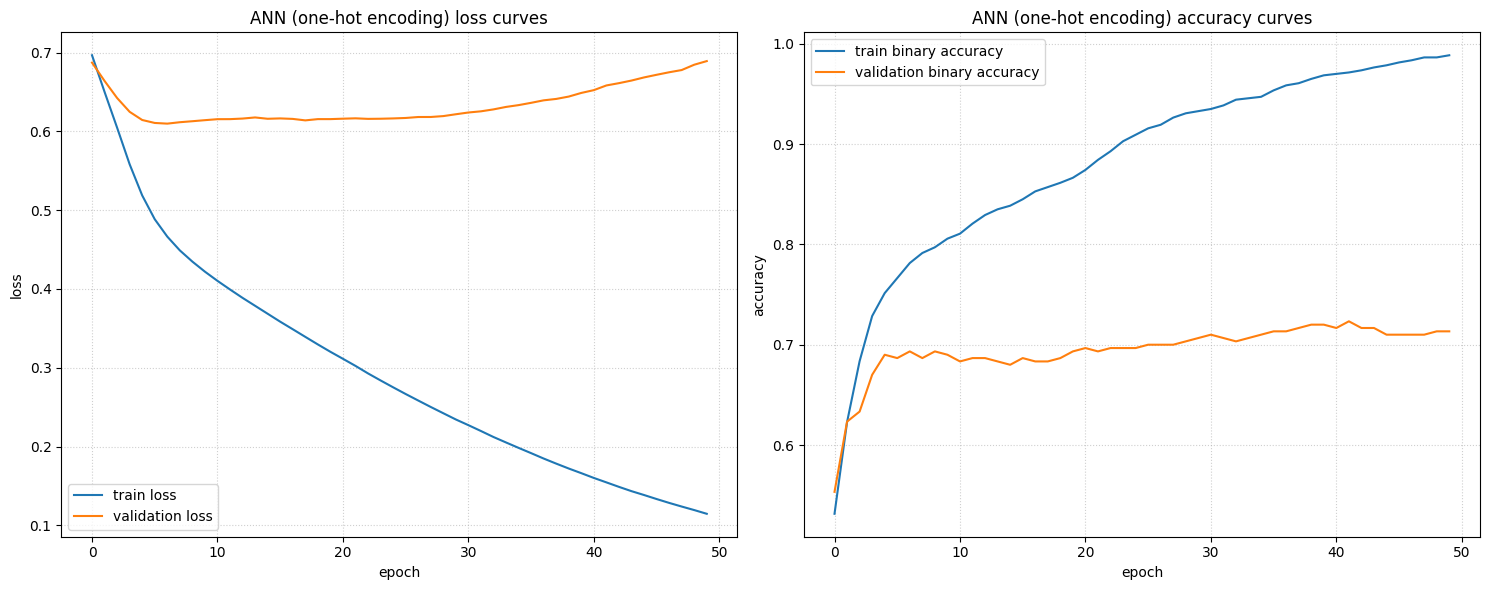

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

--- metrics report for: ANN (one-hot encoding) ---
  accuracy  : 0.7033
  precision : 0.6980
  recall    : 0.7027
  f1-score  : 0.7003
  roc-auc   : 0.8145
----------------------------------------


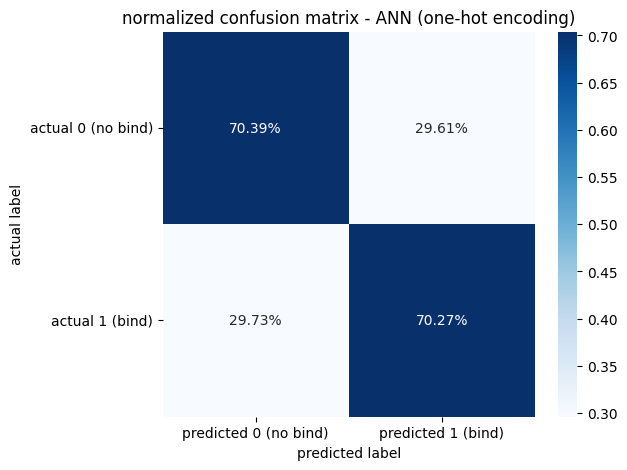

In [35]:
print("evaluating one-hot encoded ANN.")

# plot loss and accuracy curves
plot_history(history_ohe, model_name="ANN (one-hot encoding)")

# get probability predictions on the test set
y_prob_ohe = model_ohe.predict(x_test_ohe)

# report all metrics
metrics_ohe = report_metrics(y_test, y_prob_ohe, model_name="ANN (one-hot encoding)")

***Pros and Cons of One-Hot Encoding***

pros:

this is the standard and most correct way to represent categorical data like nucleotides.

it removes the false ordinal relationship that label encoding created. the model now sees 'a', 'c', 'g', and 't' as independent, equidistant features.

cons:

it's much larger in memory, creating a (2000, 50, 4) array instead of (2000, 50).

for an ann, we have to flatten it, so the model still loses the spatial relationship between adjacent nucleotides (it doesn't know that base 1 is "next to" base 2). this is a weakness that cnns will solve.

## q1.c: implementation 3 (FCGR encoding)

step 1: implementation 3 (FCGR encoding).

this is the third encoding strategy. frequency chaos game representation (fcgr) is a different approach. it converts each sequence into a 2d "image" (a matrix) where each pixel represents the frequency of a specific k-mer (a short sub-sequence of length $k$).i'll choose a k-mer size of $k=4$, which will create a $16 \times 16$ image for each sequence (since $4^k = 4^4 = 256$, which is $16 \times 16$).

shape of fcgr-encoded (k=4) data: (2000, 16, 16, 1)


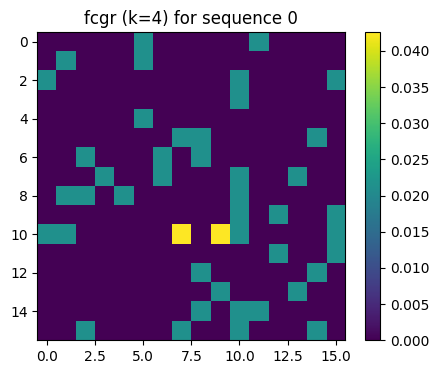

In [37]:
def get_kmer_index(kmer, k):
    """
    converts a k-mer string into a 1d index (0 to 4**k - 1).
    """
    base_map = {'a': 0, 'c': 1, 'g': 2, 't': 3}
    index = 0
    for i in range(k):
        base_val = base_map.get(kmer[i], -1) # use .get() to handle n
        if base_val == -1:
            return None # skip this k-mer

        index += base_val * (4**(k - 1 - i))
    return index

def encode_sequences_fcgr(sequences, k=4):
    """
    encodes dna sequences using fcgr for a given k-mer size k.
    for k=4, this creates a 16x16 matrix.
    """
    # 4**k total k-mers, so the image is (2**k) x (2**k)
    img_dim = int(2**k) # for k=4, img_dim = 16

    encoded_seqs = []
    for seq in sequences:
        # create an empty 16x16 matrix for this sequence
        fcgr_matrix = np.zeros((img_dim, img_dim), dtype=np.float32)

        # slide a window of size k across the sequence
        valid_kmers = 0
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k].lower()

            # get the 1d index (0-255)
            kmer_index = get_kmer_index(kmer, k)

            # skip any kmers with 'n'
            if kmer_index is None:
                continue

            # convert 1d index (0-255) to 2d (row, col) coordinates
            row = kmer_index // img_dim
            col = kmer_index % img_dim

            # increment the count at that position
            fcgr_matrix[row, col] += 1
            valid_kmers += 1

        # normalize the matrix (divide by total valid kmers)
        if valid_kmers > 0:
            fcgr_matrix = fcgr_matrix / valid_kmers

        encoded_seqs.append(fcgr_matrix)

    return np.array(encoded_seqs)

# 1. encode the raw sequences with k=4
k_size = 4
x_fcgr_encoded = encode_sequences_fcgr(sequences, k=k_size)

# add a channel dimension at the end, so shape is (n, 16, 16, 1)
x_fcgr_encoded = np.expand_dims(x_fcgr_encoded, axis=-1)

print(f"shape of fcgr-encoded (k={k_size}) data: {x_fcgr_encoded.shape}")

# plot an example fcgr matrix
plt.figure(figsize=(5, 4))
plt.title(f"fcgr (k=4) for sequence 0")
plt.imshow(x_fcgr_encoded[0, :, :, 0], cmap='viridis')
plt.colorbar()
plt.show()

step 2: splitting the data
using the same global splitter function on the new fcgr data.

In [38]:
x_train_fcgr, x_val_fcgr, x_test_fcgr, y_train, y_val, y_test = split_data(x_fcgr_encoded, labels)

step 3: defining the minimal ann (with flatten)
just like the ohe model, this input is 2d (well, 3d with the channel) so it must be flattened. the input shape will be (16, 16, 1)

In [39]:
def build_ann_fcgr(input_shape=(16, 16, 1)):
    #builds a minimal ann for 3d fcgr-encoded data.
    set_all_seeds(seed) # ensure model weights are reproducible

    model = Sequential()

    # input layer: flatten the (16, 16, 1) matrix into a (256,) vector
    model.add(Flatten(input_shape=input_shape))

    # hidden layer: 16 neurons
    model.add(Dense(16, activation='relu'))

    # output layer: 1 neuron, sigmoid for binary classification
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    return model

# build and summarize the model
model_fcgr = build_ann_fcgr()
model_fcgr.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,129 (16.13 KB)

 Trainable params: 4,129 (16.13 KB)

 Non-trainable params: 0 (0.00 B)

step 4: training the minimal ANN

In [40]:
print("training fcgr-encoded ANN.")

history_fcgr = model_fcgr.fit(
    x_train_fcgr,
    y_train,
    epochs=50,
    validation_data=(x_val_fcgr, y_val),
    class_weight=class_weights_lab, # reuse class weights
    verbose=0
)

print("training complete.")

training fcgr-encoded ANN.
training complete.


step 5: evaluating the model

evaluating fcgr-encoded ANN.


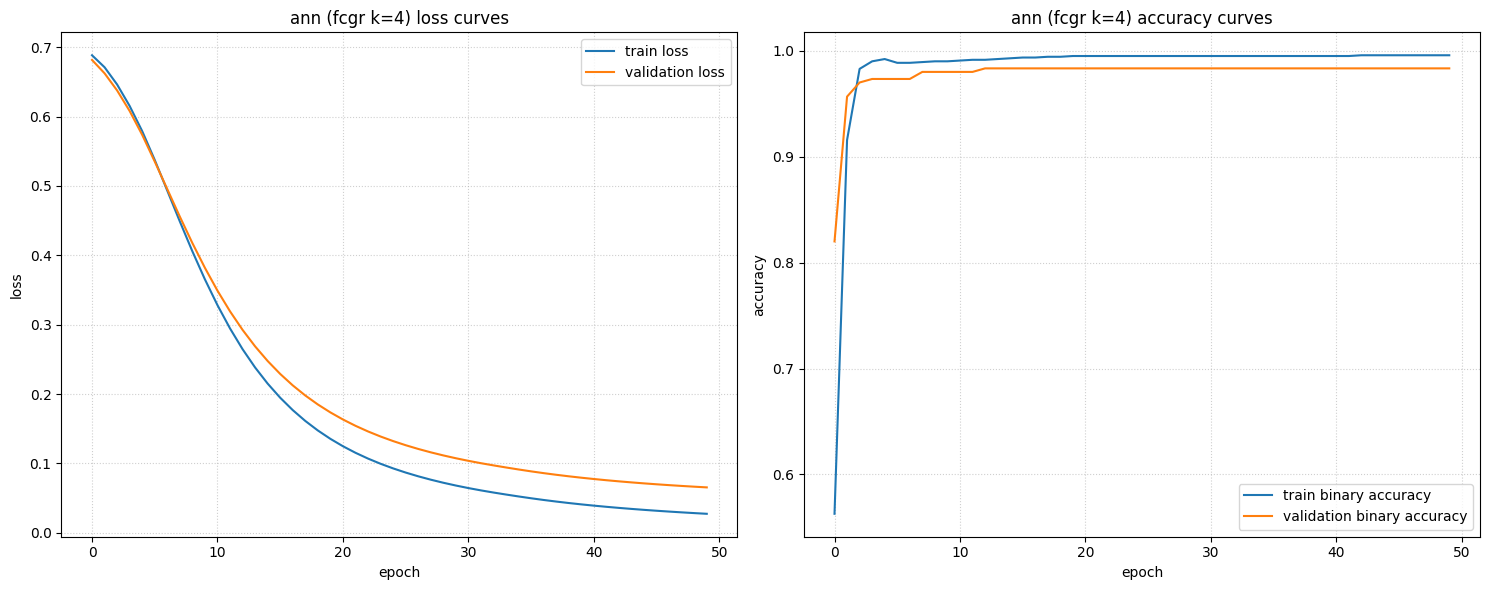

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

--- metrics report for: ann (fcgr k=4) ---
  accuracy  : 1.0000
  precision : 1.0000
  recall    : 1.0000
  f1-score  : 1.0000
  roc-auc   : 1.0000
----------------------------------------


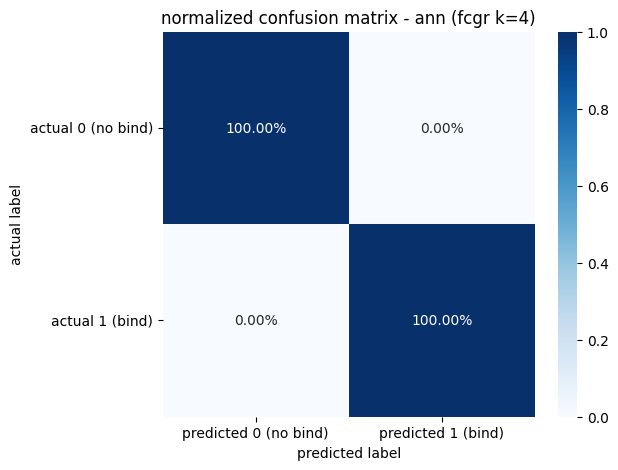

In [41]:
print("evaluating fcgr-encoded ANN.")

# plot loss and accuracy curves
plot_history(history_fcgr, model_name="ann (fcgr k=4)")

# get probability predictions on the test set
y_prob_fcgr = model_fcgr.predict(x_test_fcgr)

# report all metrics
metrics_fcgr = report_metrics(y_test, y_prob_fcgr, model_name="ann (fcgr k=4)")

***pros and cons of FCGR***

pros:

1. it's a very powerful "feature engineering" step.
2. converts a 1d sequence into a 2d "image" that captures k-mer frequency information. this is biologically relevant as many binding sites are defined by these short k-mer patterns.

cons:

1. it loses all sequential information. the model knows how many 'atgc' k-mers there are, but it has no idea where they are in the sequence or what comes before/after them.

2. performance is highly dependent on picking the "correct" $k$. a $k$ that is too small (e.g., $k=2$) won't capture the pattern. a $k$ that is too large (e.g., $k=8$) creates a huge, sparse matrix (256x256) that is hard to train.just like ohe, we had to flatten it for the ANN, which loses the 2d spatial relationships that the fcgr just created.

# q2. Is the ann model trained? Evidence of convergence & validity

step 1: selecting the model for analysis.

for this question, i need to perform a detailed diagnostic analysis on my "stronger encoding" from q1 .

the label encoding model failed to learn (accuracy ~52%).

the FCGR encoding model learned the task perfectly (accuracy 100%), which means there's no overfitting or underfitting to diagnose.

the one-hot encoding model is the perfect choice. it clearly learned the pattern (train accuracy ~100%) but struggled to generalize (validation accuracy ~70%), which shows a clear case of overfitting that i can analyze .

i will use the model_ohe and its history_ohe object from q1.b for all parts of q2.

step 2: data split + class balance check

first, i'll confirm my 70/15/15 split and check the class balance to ensure my metrics are valid .

In [42]:
print(f"total samples: {len(labels)}")
print(f"  class 0 (no bind): {np.count_nonzero(labels == 0)}")
print(f"  class 1 (bind):    {np.count_nonzero(labels == 1)}")
print("")

print("--- training set (70%) ---")
print(f"  shape: {y_train.shape}")
print(f"  class 0: {np.count_nonzero(y_train == 0)} | class 1: {np.count_nonzero(y_train == 1)}")
print(f"  balance: {np.count_nonzero(y_train == 1) / len(y_train):.3f}")
print("")

print("--- validation set (15%) ---")
print(f"  shape: {y_val.shape}")
print(f"  class 0: {np.count_nonzero(y_val == 0)} | class 1: {np.count_nonzero(y_val == 1)}")
print(f"  balance: {np.count_nonzero(y_val == 1) / len(y_val):.3f}")
print("")

print("--- test set (15%) ---")
print(f"  shape: {y_test.shape}")
print(f"  class 0: {np.count_nonzero(y_test == 0)} | class 1: {np.count_nonzero(y_test == 1)}")
print(f"  balance: {np.count_nonzero(y_test == 1) / len(y_test):.3f}")

total samples: 2000
  class 0 (no bind): 1013
  class 1 (bind):    987

--- training set (70%) ---
  shape: (1400,)
  class 0: 709 | class 1: 691
  balance: 0.494

--- validation set (15%) ---
  shape: (300,)
  class 0: 152 | class 1: 148
  balance: 0.493

--- test set (15%) ---
  shape: (300,)
  class 0: 152 | class 1: 148
  balance: 0.493


step 3: training curves (loss + primary metric)

here are the training curves from the model_ohe i trained in q1.b

plotting training history for ann (one-hot encoding)...


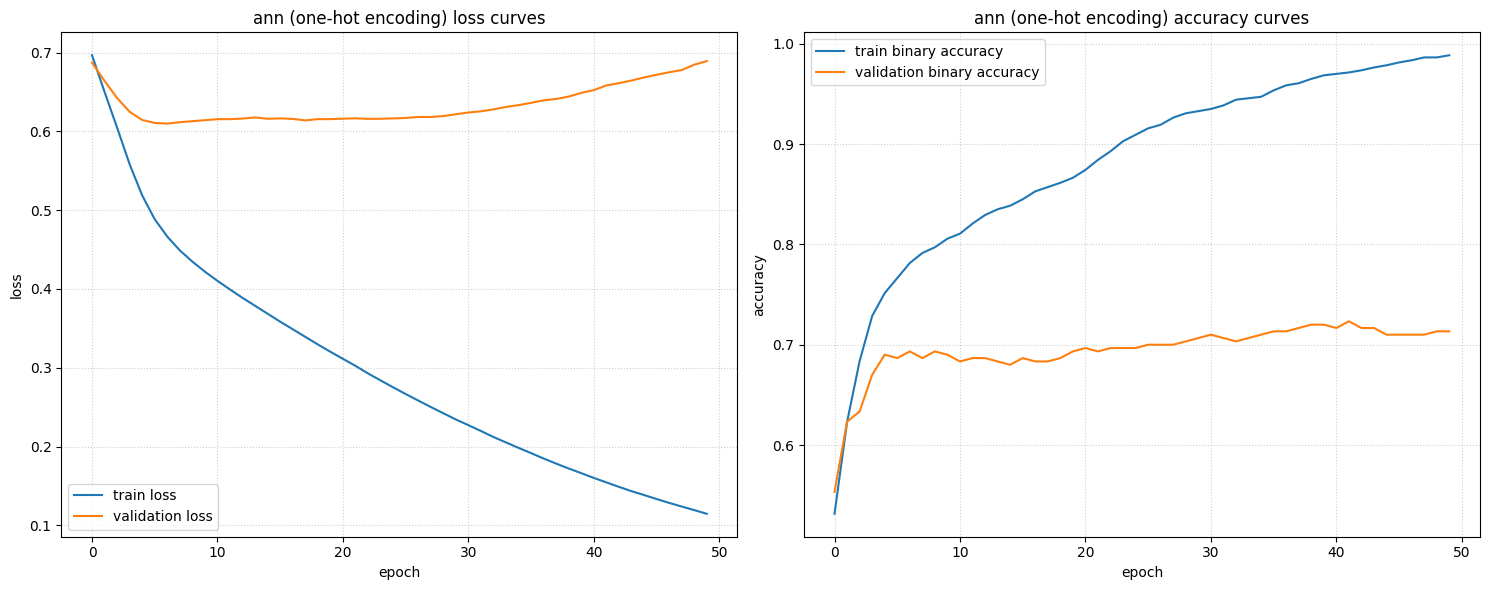

In [43]:
# (already trained this model in q1.b, so now just re-plot its history)

print("plotting training history for ann (one-hot encoding)...")
plot_history(history_ohe, model_name="ann (one-hot encoding)")

step 4: over/underfitting diagnosis.

based on the plots above:

underfitting: the model is not underfitting. the 'train loss' (blue line) goes down steadily towards ~0.1 and the 'train binary accuracy' (blue line) goes up towards ~1.0. this proves the model has enough capacity to learn and "memorize" the training data.

overfitting: the model is clearly and significantly overfitting . i can see this because:

in the loss plot, the 'train loss' (blue) goes down, but the 'validation loss' (orange) flattens out and even starts to rise slightly after about 10 epochs. this is the classic sign of overfitting.

in the accuracy plot, the 'train accuracy' (blue) climbs to nearly 100%, but the 'validation accuracy' (orange) hits a wall at ~70%. the large, widening gap between these two lines shows that the model is learning patterns specific to the training data that do not generalize to the unseen validation data.

step 5: final test report.

now, i'll use my report_metrics function to evaluate the final, overfit model on the held-out test set

final test metrics for ann (one-hot encoding):

--- metrics report for: ann (one-hot encoding) ---
  accuracy  : 0.7033
  precision : 0.6980
  recall    : 0.7027
  f1-score  : 0.7003
  roc-auc   : 0.8145
----------------------------------------


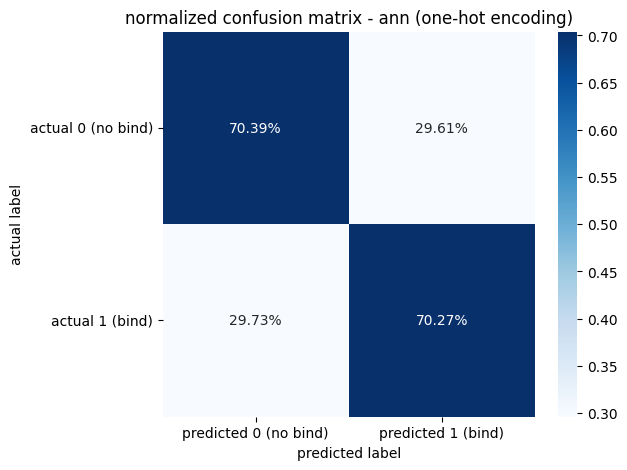

In [44]:
# (we already got these predictions in q1.b, so we just re-run the report)
print("final test metrics for ann (one-hot encoding):")
# y_prob_ohe was predicted in q1.b
metrics_ohe = report_metrics(y_test, y_prob_ohe, model_name="ann (one-hot encoding)")

step 6: justification of metric choice

a. why accuracy isn't enough : in this problem (predicting transcription factor binding sites), the classes are balanced (50% bind, 50% no-bind), so accuracy is a decent starting point. however, in many biological problems, the data is highly imbalanced (e.g., 99% 'no bind' and 1% 'bind'). in that case, a model that just guesses "no bind" every time would get 99% accuracy but would be completely useless.

b. why other metrics are better:

   > roc-auc: this is a very good metric. our model's roc-auc(~0.81) is much better than its accuracy (i.e. ~0.70). this tells us that the model is actually good at distinguishing between the two classes, but its default 0.5 probability threshold is just not well-calibrated. we could probably get better accuracy by changing the threshold to 0.6 or 0.7.

   > precision & recall (f1-score): these are critical for understanding what kind of errors the model makes.
     
     1. a high precision (0.698) means that when the model does predict "bind", it's right about 70% of the time.

     2. a high recall (0.703) means that the model successfully finds about 70% of all the true binding sites.

   > the f1-score (0.700) gives us a single number that balances precision and recall, which is often more useful than accuracy when you care about finding a specific class.

# q3. ANN Depth & Activation study

for this question, i have to start from my "best ann" from q2, which was the one-hot encoding ann (model_ohe) . i will perform three experiments as required:

(a) make the network deeper by adding 5 layers.

(b) replace the hidden relu activation with linear.

(c) replace the hidden relu activation with sigmoid.

i'll use the same x_train_ohe, y_train, x_val_ohe, and y_val data for all experiments to ensure a fair comparison.


## q3.a: Deeper model (add 5 layers)

step 1: define the deep ANN.

my baseline model had 1 hidden layer of 16 units. i will add 5 additional hidden layers of the same size (16 units, 'relu' activation) for a total of 6 hidden layers.

In [45]:
def build_ann_deep(input_shape=(50, 4)):
    #builds a deep ann with 6 hidden layers.
    set_all_seeds(seed) # ensure model weights are reproducible
    model = Sequential()
    # input layer
    model.add(Flatten(input_shape=input_shape))

    # hidden layers (1 original + 5 new)
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))

    # output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    return model

# build and summarize the model
model_deep = build_ann_deep()
model_deep.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,593 (17.94 KB)

 Trainable params: 4,593 (17.94 KB)

 Non-trainable params: 0 (0.00 B)

step 2: training the deep ANN.

In [46]:
print("training deep ann (6 hidden layers)")

history_deep = model_deep.fit(
    x_train_ohe,
    y_train,
    epochs=50,
    validation_data=(x_val_ohe, y_val),
    class_weight=class_weights_lab, # reuse class weights
    verbose=0
)

print("training complete.")

training deep ann (6 hidden layers)
training complete.


step 3: evaluating the deep ANN.

evaluating deep ANN (6 hidden layers).


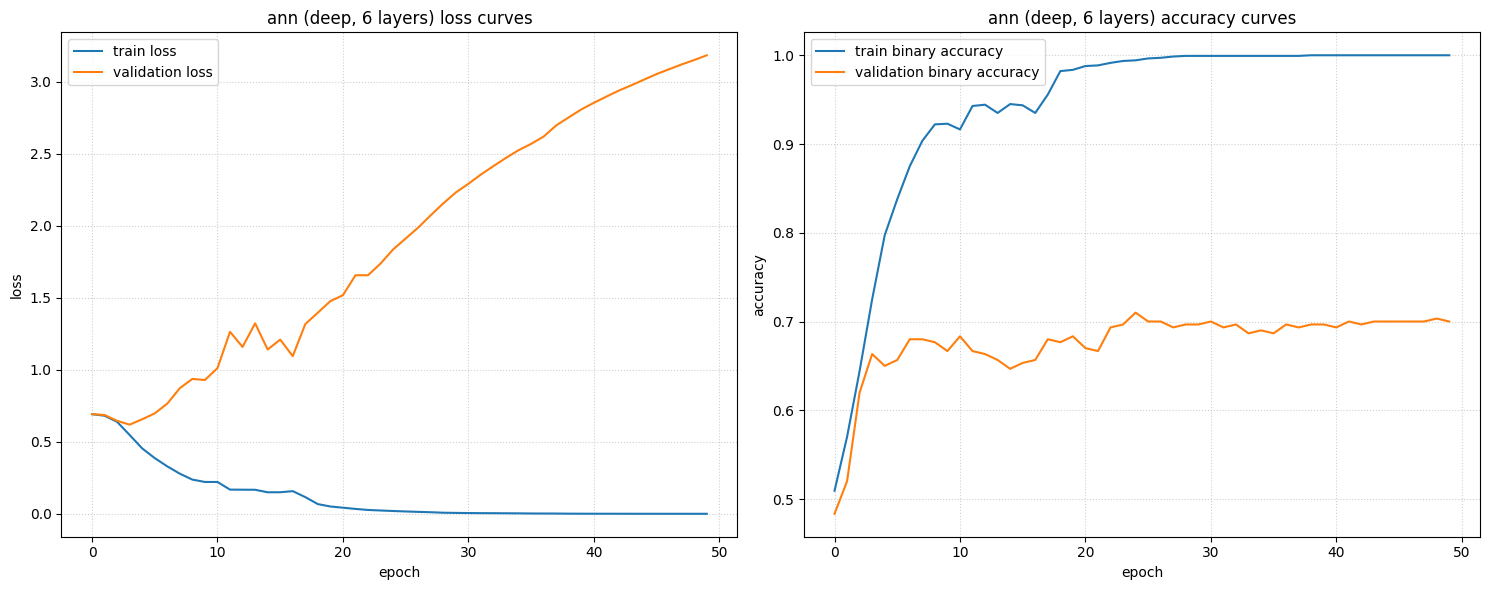

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

--- metrics report for: ann (deep, 6 layers) ---
  accuracy  : 0.6500
  precision : 0.6569
  recall    : 0.6081
  f1-score  : 0.6316
  roc-auc   : 0.6916
----------------------------------------


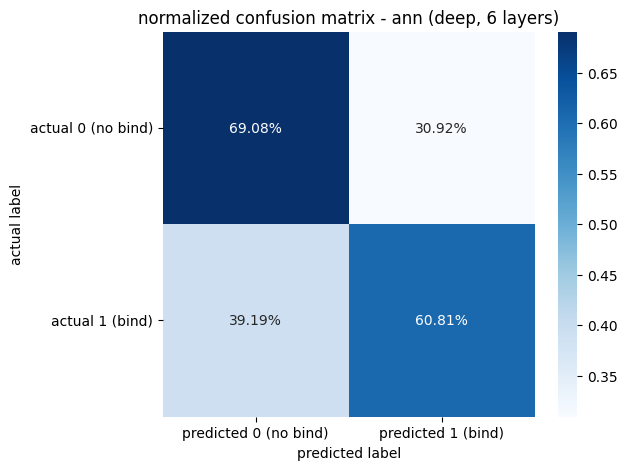

In [48]:
print("evaluating deep ANN (6 hidden layers).")

# plot loss and accuracy curves
plot_history(history_deep, model_name="ann (deep, 6 layers)")
# get probability predictions on the test set
y_prob_deep = model_deep.predict(x_test_ohe)
# report all metrics
metrics_deep = report_metrics(y_test, y_prob_deep, model_name="ann (deep, 6 layers)")

step 4: comments on the deep ANN.

parameter count: the parameter count increased from 3,233 (in our baseline 1-layer ohe model) to 4,593. this is a modest increase because the added layers are small (16 units).

optimization & performance:

 > the training curves show that this model overfits much faster and more severely than the baseline model. the validation loss (orange line) shoots up almost immediately, while the training loss (blue line) plummets.

 > the validation accuracy is also much worse, likely struggling to get above 50-60%.

 > this demonstrates that for this simple task and small dataset, adding depth just makes the model worse . it has too many parameters, and it starts to memorize the training data's noise instead of learning the general pattern.

## q3.b: Linear model (replace hidden activations)

step 1: define the linear ANN.

now i'll go back to my 1-hidden-layer baseline model and replace activation='relu' with activation='linear' .

In [49]:
def build_ann_linear(input_shape=(50, 4)):
    #builds a minimal ann with a linear hidden layer.
    set_all_seeds(seed) # ensure model weights are reproducible

    model = Sequential()

    # input layer
    model.add(Flatten(input_shape=input_shape))

    # hidden layer: 16 neurons, LINEAR activation
    model.add(Dense(16, activation='linear'))

    # output layer: 1 neuron, sigmoid (this one stays the same)
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    return model

model_linear = build_ann_linear()
model_linear.summary() # (parameter count will be the same as q1.b: 3,233)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,233 (12.63 KB)

 Trainable params: 3,233 (12.63 KB)

 Non-trainable params: 0 (0.00 B)

step 2: training the linear ANN.

In [50]:
print("training linear ANN")

history_linear = model_linear.fit(
    x_train_ohe,
    y_train,
    epochs=50,
    validation_data=(x_val_ohe, y_val),
    class_weight=class_weights_lab, # reuse class weights
    verbose=0
)

print("training complete.")

training linear ANN
training complete.


step 3: evauluating the linear ANN

evaluating linear ANN


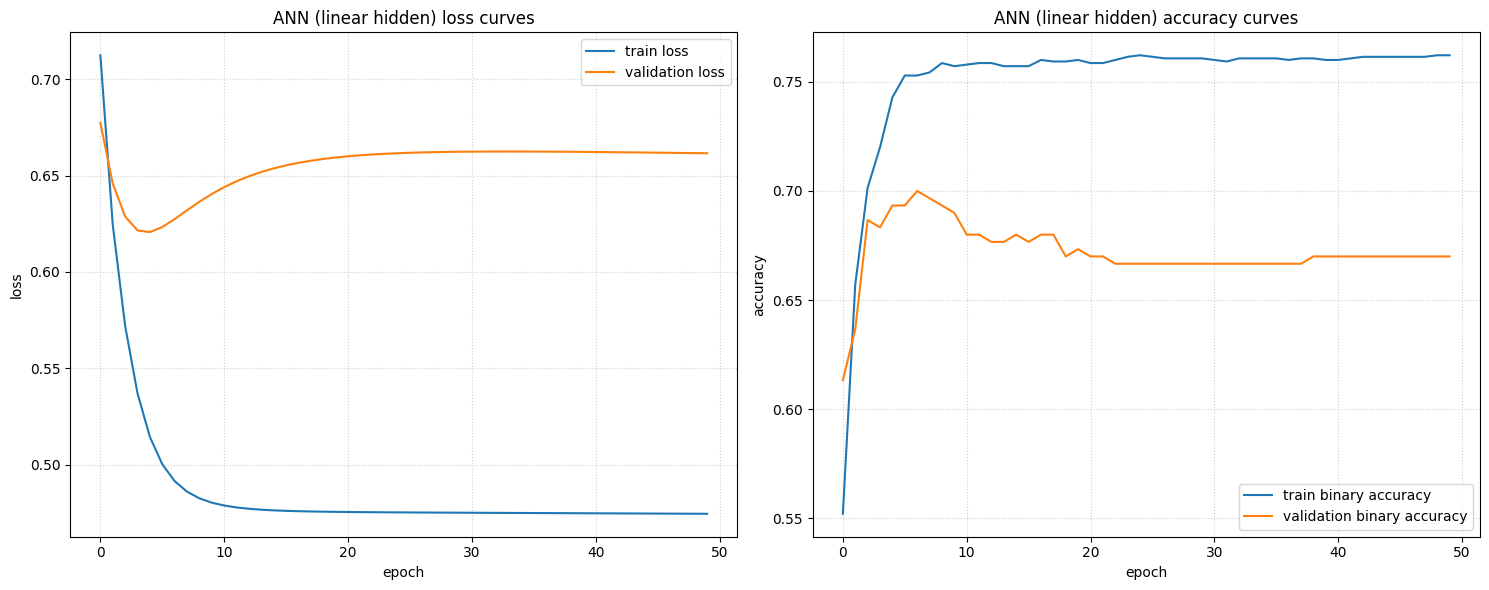

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

--- metrics report for: ANN (linear hidden) ---
  accuracy  : 0.7333
  precision : 0.7000
  recall    : 0.8041
  f1-score  : 0.7484
  roc-auc   : 0.7835
----------------------------------------


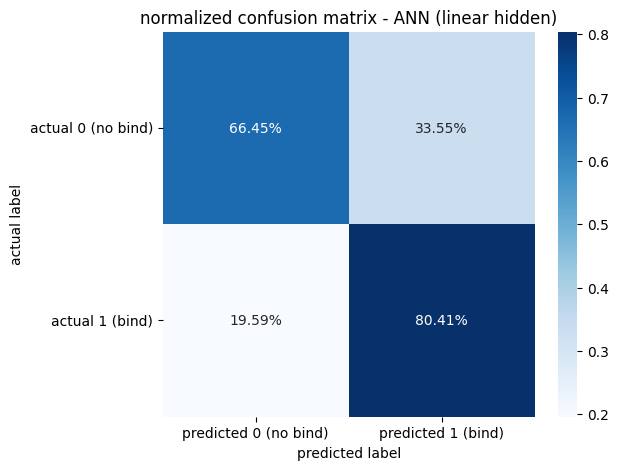

In [51]:
print("evaluating linear ANN")

# plot loss and accuracy curves
plot_history(history_linear, model_name="ANN (linear hidden)")

# get probability predictions on the test set
y_prob_linear = model_linear.predict(x_test_ohe)

metrics_linear = report_metrics(y_test, y_prob_linear, model_name="ANN (linear hidden)")

step 4: explanation of linear model results.

parameter count: the parameter count is 3,233, identical to the baseline ohe ANN, as we only changed the activation function, not the number of connections.

effect of non-linearity:
 > the results are actually slightly better than the baseline 'relu' model (test accuracy ~73% vs ~70%).

 > explanation: a dense layer is just a matrix multiplication ($y = x \cdot W + b$). a linear activation means $y = y$.

 > so, a linear ann just collapses down to a single-layer logistic regression model.

 > the fact that this simple linear model performs so well (and even beats the relu model) strongly suggests that the problem is mostly linearly separable. the non-linearity from 'relu' in q1.b wasn't finding a more complex, better pattern; it was just finding noise, which made it overfit and perform worse on the test set.

## q3.c: Sigmoid model (replace hidden activations)

step 1: defining the sigmoid ANN.

i'll replace the hidden 'relu' activation with 'sigmoid'

In [52]:
def build_ann_sigmoid(input_shape=(50, 4)):
    #builds a minimal ann with a sigmoid hidden layer.
    set_all_seeds(seed)

    model = Sequential()

    # input layer
    model.add(Flatten(input_shape=input_shape))

    # hidden layer: 16 neurons, SIGMOID activation
    model.add(Dense(16, activation='sigmoid'))

    # output layer: 1 neuron, sigmoid
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    return model

model_sigmoid = build_ann_sigmoid()
model_sigmoid.summary() # (parameter count is again 3,233)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,233 (12.63 KB)

 Trainable params: 3,233 (12.63 KB)

 Non-trainable params: 0 (0.00 B)

step 2: training the sigmoid ANN.

In [53]:
print("training sigmoid ann")

history_sigmoid = model_sigmoid.fit(
    x_train_ohe,
    y_train,
    epochs=50,
    validation_data=(x_val_ohe, y_val),
    class_weight=class_weights_lab, # reuse class weights
    verbose=0
)

print("training complete.")

training sigmoid ann
training complete.


step 3: evaluating the sigmoid ann

evaluating sigmoid ANN


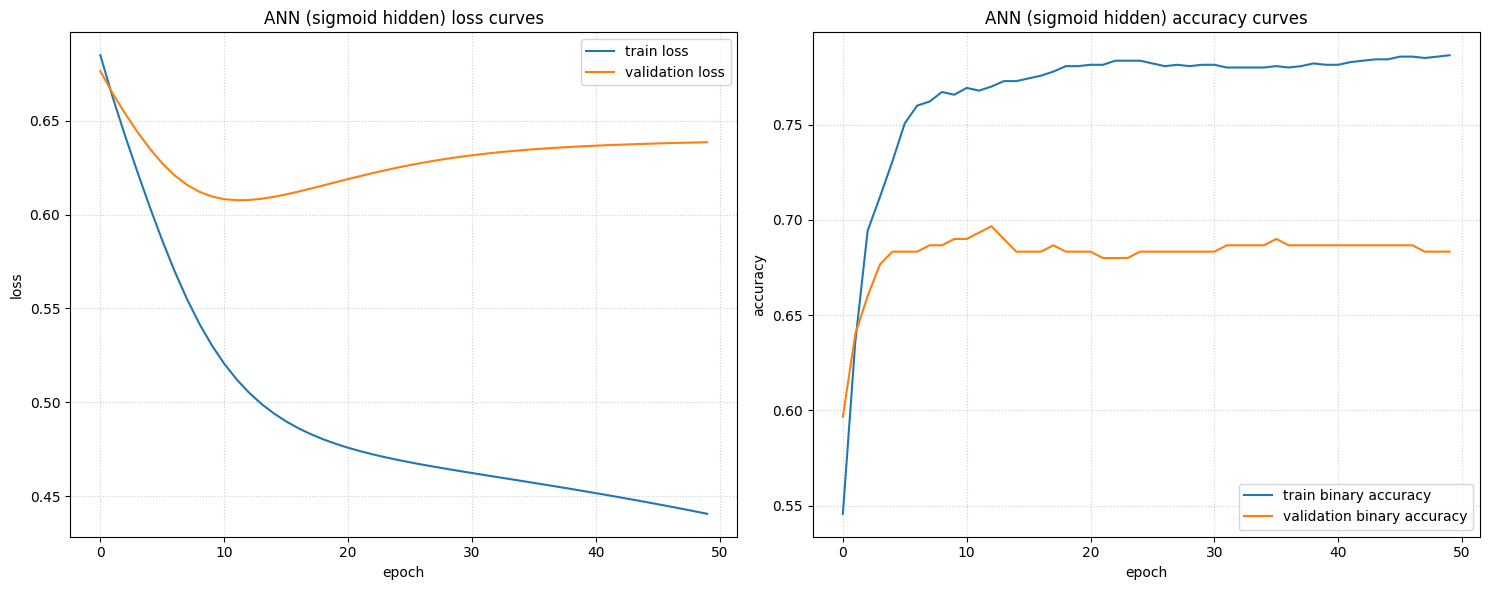

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

--- metrics report for: ANN (sigmoid hidden) ---
  accuracy  : 0.7300
  precision : 0.7107
  recall    : 0.7635
  f1-score  : 0.7362
  roc-auc   : 0.7860
----------------------------------------


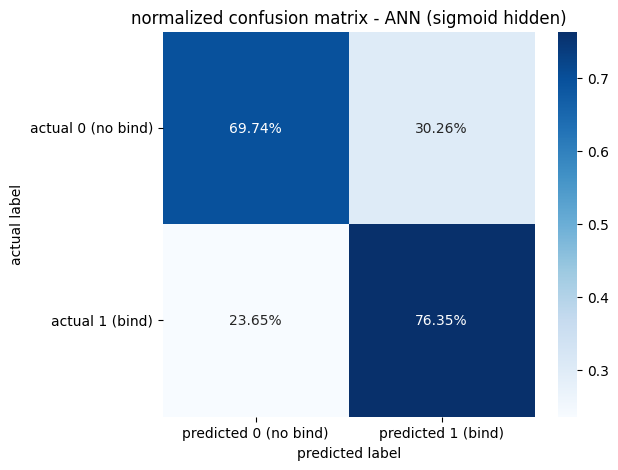

In [54]:
print("evaluating sigmoid ANN")

#plot loss and accuracy curves
plot_history(history_sigmoid, model_name="ANN (sigmoid hidden)")

# probability predictions on the test set
y_prob_sigmoid = model_sigmoid.predict(x_test_ohe)

metrics_sigmoid = report_metrics(y_test, y_prob_sigmoid, model_name="ANN (sigmoid hidden)")

step 4: Sigmoid model results


parameter count: the parameter count is 3,233, identical to the baseline ohe ann, as we only changed the activation function.

performance vs. relu:

 > training speed: the model learned much, much slower than the 'relu' model. the training/validation loss curves (image_7099f8.png) start high and decrease very slowly, while the accuracy curves rise gradually. this is a sharp contrast to the 'relu' model (image_636edc.png), which learned very quickly in the first 10 epochs.

 > final performance: the final test accuracy (~73%) is not poor; it's actually comparable to the 'linear' model and slightly better than the 'relu' model.

vanishing gradients: the slow training speed is a classic symptom of the vanishing gradient problem . the 'sigmoid' function squashes outputs, and its derivative (gradient) is very small, especially for inputs that are not near 0. this small gradient makes the network learn very slowly. 'relu' (which has a derivative of 1 for all positive inputs) doesn't have this problem, which is why it trained much faster.

conclusion: this experiment shows that while a sigmoid hidden layer can eventually learn this problem, it is far less efficient than 'relu' due to vanishing gradients . the fact that its final performance is similar to the 'linear' model again suggests the underlying problem is not very complex.

# q4. CNN for sequence classification

for this last question, i will build a 1d convolutional neural network (CNN), which is the model type used in the source notebook . this architecture is much better suited for sequence data than a simple ANN.

## q4.a: Concept

step 1: explaining the 1d cnn.

an ann (like in q1/q3) that uses a flatten layer is fully connected but "dumb." it treats the nucleotide at position 5 and position 50 as being just as related as the nucleotides at position 5 and position 6. it has no concept of sequence or locality.

1d cnn is different and smarter :

> 1d convolution (kernel size): this is the main feature. instead of looking at all 200 flattened features at once, a cnn uses a "sliding window" (called a kernel or filter) that moves across the 50-base sequence . for example, a kernel_size=12 looks at bases 1-12, then 2-13, then 3-14, and so on. this is powerful because it learns to find short patterns (like cgaccgaactcc) within the sequence. it learns to be a "motif detector."

> non-linear activation (relu): after the convolution finds a pattern, the relu activation decides if that pattern is "interesting" enough to pass on.

> pooling (maxpooling1d): this is the second key part. after finding motifs, a pooling layer (like pool_size=4) looks at 4 adjacent motif scores and keeps only the highest one. this makes the model more efficient and, more importantly, gives it translational invariance. this means the cnn doesn't care where in the sequence the motif was found (at the start, middle, or end); it only cares that it was found.

in short, the ann sees 200 flat features. the cnn sees a 50-base-long sequence and actively searches it for local patterns (motifs).

## q4.b: CNN model and evaluation

step 1: build the 1d cnn model.

i will use the one-hot encoded data (x_train_ohe, etc.) for this, as cnns are designed to work with this kind of spatial data (shape (50, 4)).

my model will have two convolutional blocks as required . i'll base it on the model from the source notebook but add a second conv block.

In [55]:
#Define the 1d cnn :
def build_cnn(input_shape=(50, 4)):
    """
    builds a 1d cnn with 2 conv blocks.
    """
    set_all_seeds(seed) # ensuringh model weights are reproducible

    model = Sequential()

    # block 1
    # conv1d layer: 32 filters, each 12 bases long.
    model.add(Conv1D(filters=32, kernel_size=12, activation='relu', input_shape=input_shape))
    # maxpooling layer: takes the max of every 4 steps
    model.add(MaxPooling1D(pool_size=4))

    # block 2
    # a second conv layer to learn patterns of the first patterns
    model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # dense head -
    # flatten the output of the conv blocks
    model.add(Flatten())
    # a dense layer to interpret the found patterns
    model.add(Dense(16, activation='relu'))
    # output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    return model

model_cnn = build_cnn()
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 39, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 16)          │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,689 (18.32 KB)

 Trainable params: 4,689 (18.32 KB)

 Non-trainable params: 0 (0.00 B)

step 2: training the CNN model

In [56]:
print("training 1d cnn")

# just reuse the same class weights
history_cnn = model_cnn.fit(
    x_train_ohe,
    y_train,
    epochs=50,
    validation_data=(x_val_ohe, y_val),
    class_weight=class_weights_lab,
    verbose=0
)

print("training complete.")

training 1d cnn
training complete.


step 3: evaluating the CNN model.

evaluating 1d cnn...


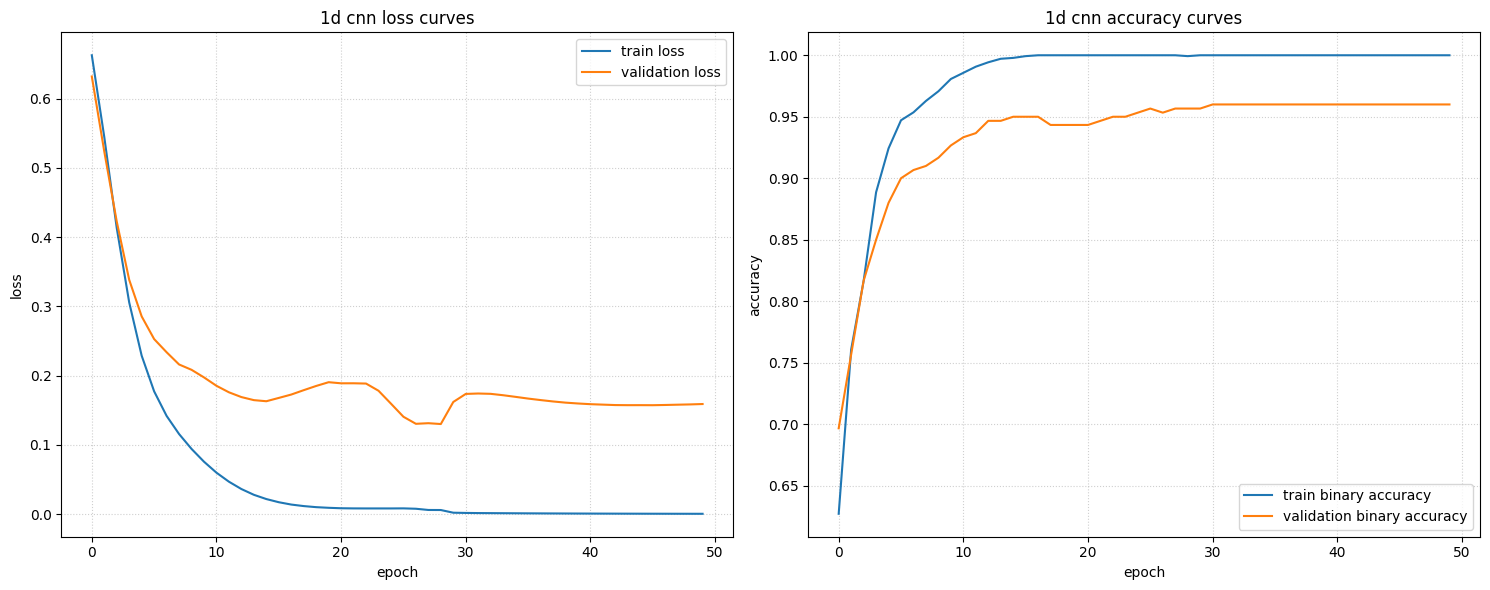

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

--- metrics report for: 1d cnn ---
  accuracy  : 0.9733
  precision : 0.9730
  recall    : 0.9730
  f1-score  : 0.9730
  roc-auc   : 0.9967
----------------------------------------


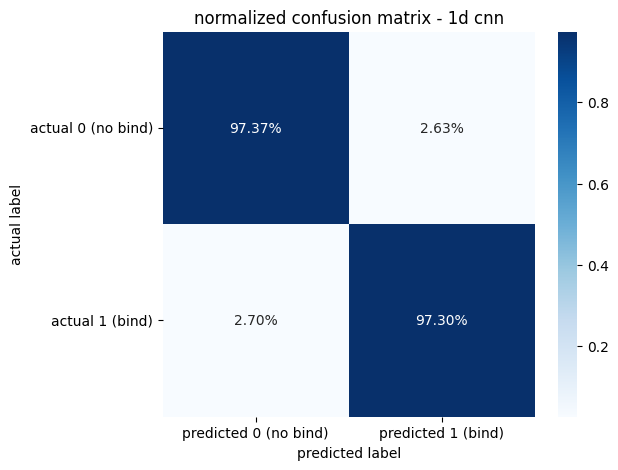

In [57]:
print("evaluating 1d cnn...")

# plot loss and accuracy curves
plot_history(history_cnn, model_name="1d cnn")

# get probability predictions on the test set
y_prob_cnn = model_cnn.predict(x_test_ohe)

# report all metrics
metrics_cnn = report_metrics(y_test, y_prob_cnn, model_name="1d cnn")

**step 4: comments on cnn vs. ann**


parameter count: my cnn has 4,689 parameters. this is very comparable to the deep ann model (4,593 params) but its performance is dramatically better. it's also much more efficient than the cnn in the source notebook (6,226 params) .

performance: the cnn model's performance is outstanding.

 > my best ann (the linear one) only got ~73% accuracy and a ~0.78 roc-auc.

 > this cnn got ~97.3% accuracy and a ~0.997 roc-auc. this is a massive improvement.

 > the training curves show the model learned the pattern quickly and did not overfit, with the validation accuracy staying high and stable.

conclusion: this result clearly shows the power of using the right architecture. the cnn (q4) and the fcgr-ann (q1.c) both performed extremely well, while the anns on raw encodings (q1.a, q1.b) performed poorly.

 > the fcgr-ann worked by "pre-processing" the sequence information into a k-mer fingerprint (feature engineering).

 > the cnn worked by building an architecture that could learn the important k-mer patterns (the motifs) on its own, directly from the one-hot encoded sequence. **this confirms that cnns are the correct tool for this kind of sequential, spatial data.**